In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.pipeline       import Pipeline 
from functools import partial
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import tensorflow_text as tf_text
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import Model, Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

2024-02-27 10:14:03.002854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 10:14:03.002981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 10:14:03.177527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Import dataset to work environment

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


### Exploratory Data Analysis

In [3]:
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
sample = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

In [4]:
# Load the first file: test.csv
file_path_test = '/kaggle/input/llm-detect-ai-generated-text/test_essays.csv'
test_essays_df = pd.read_csv(file_path_test)

test_essays_df.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [5]:
test_essays_df.shape

(3, 3)

In [6]:
file_path_train_prompts = '/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv'
train_prompts_df = pd.read_csv(file_path_train_prompts)

train_prompts_df.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [7]:
file_path_train_prompts = '/kaggle/input/llm-detect-ai-generated-text/train_essays.csv'
train_essays_df = pd.read_csv(file_path_train_prompts)
train_essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns



basic_stats = {
    "Total Entries": len(test_essays_df),
    "Unique IDs": test_essays_df["id"].nunique(),
    "Unique Prompt IDs": test_essays_df["prompt_id"].nunique(),
}

all_words = ' '.join(test_essays_df['text']).split()
word_frequency = Counter(all_words)

test_essays_df['text_length'] = test_essays_df['text'].apply(len)

basic_stats, word_frequency, test_essays_df['text_length'].describe()

({'Total Entries': 3, 'Unique IDs': 3, 'Unique Prompt IDs': 3},
 Counter({'Aaa': 1,
          'bbb': 1,
          'ccc.': 1,
          'Bbb': 1,
          'ccc': 1,
          'ddd.': 1,
          'CCC': 1,
          'ddd': 1,
          'eee.': 1}),
 count     3.0
 mean     12.0
 std       0.0
 min      12.0
 25%      12.0
 50%      12.0
 75%      12.0
 max      12.0
 Name: text_length, dtype: float64)

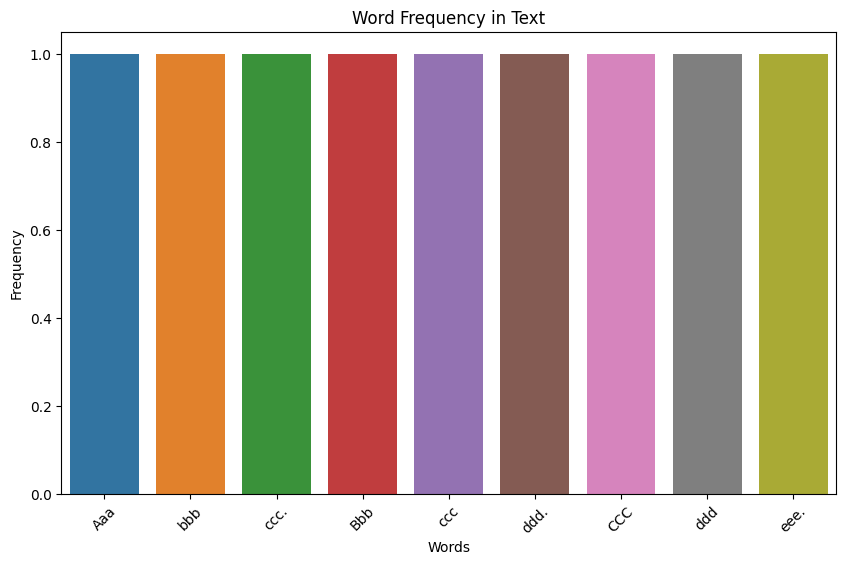

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(word_frequency.keys()), y=list(word_frequency.values()))
plt.title("Word Frequency in Text")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [10]:
missing_values_train = train_essays_df.isnull().sum()
print("missing_values_train:", missing_values_train)
missing_values_test = test_essays_df.isnull().sum()
print("\nmissing_values_train:", missing_values_train)
missing_values_prompts = train_prompts_df.isnull().sum()
print("\nmissing_values_prompts:", missing_values_prompts)

missing_values_train: id           0
prompt_id    0
text         0
generated    0
dtype: int64

missing_values_train: id           0
prompt_id    0
text         0
generated    0
dtype: int64

missing_values_prompts: prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64


In [11]:
train_essays_df['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

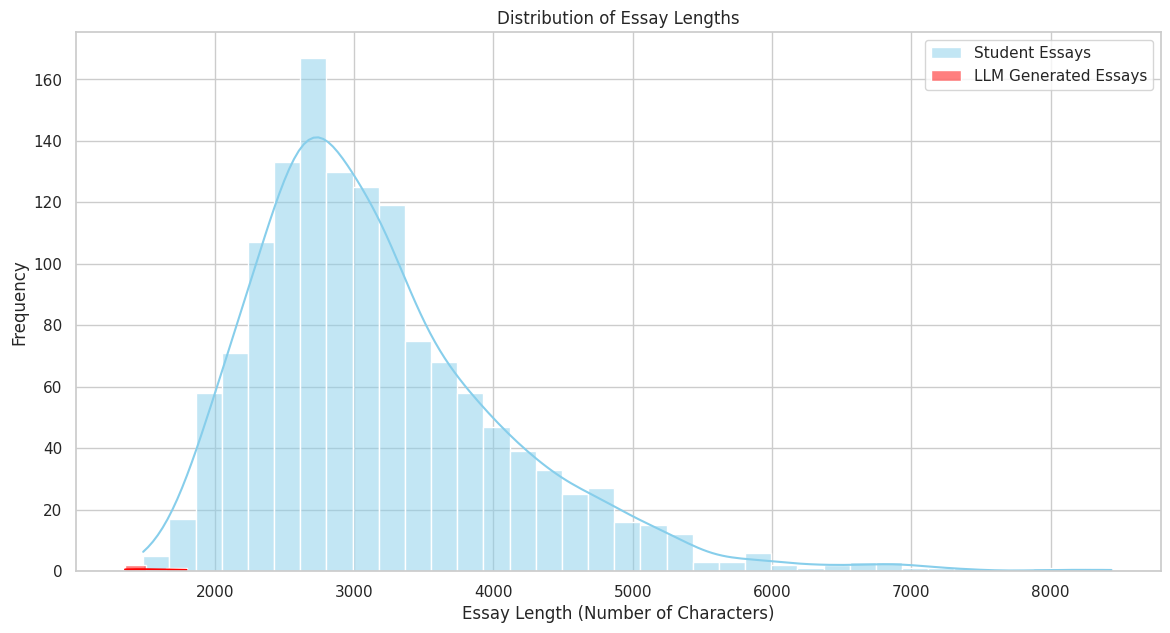

In [12]:
train_essays_df['essay_length'] = train_essays_df['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.histplot(train_essays_df[train_essays_df['generated'] == 0]['essay_length'], color="skyblue", label='Student Essays', kde=True)

sns.histplot(train_essays_df[train_essays_df['generated'] == 1]['essay_length'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

'Prompt Usage Frequency'

prompt_id
0    708
1    670
Name: count, dtype: int64

'Average Essay Length by Prompt'

prompt_id
0    3251.927966
1    3081.473134
Name: essay_length, dtype: float64

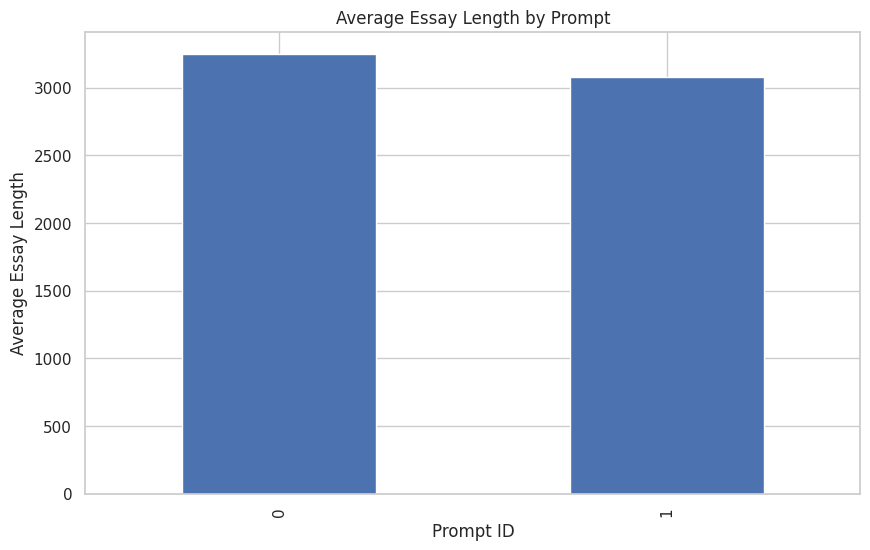

In [13]:
train_essays_df['essay_length'] = train_essays_df['text'].apply(len)

merged_df = train_essays_df.merge(train_prompts_df, on='prompt_id', how='left')

prompt_usage = merged_df['prompt_id'].value_counts()

avg_length_by_prompt = merged_df.groupby('prompt_id')['essay_length'].mean()

display("Prompt Usage Frequency")
display(prompt_usage)

display("Average Essay Length by Prompt")
display(avg_length_by_prompt)

plt.figure(figsize=(10, 6))
avg_length_by_prompt.plot(kind='bar')
plt.title('Average Essay Length by Prompt')
plt.xlabel('Prompt ID')
plt.ylabel('Average Essay Length')
plt.show()

In [14]:
def calculate_text_metrics_simple(text):
    words = text.split()
    sentences = text.split('.')
    word_count = len(words)
    unique_word_count = len(set(words))
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sentence_count, avg_word_length

train_essays_df['metrics'] = train_essays_df['text'].apply(calculate_text_metrics_simple)

train_essays_df[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']] = pd.DataFrame(train_essays_df['metrics'].tolist(), index=train_essays_df.index)

train_essays_df.drop('metrics', axis=1, inplace=True)

comparison_metrics = train_essays_df.groupby('generated')[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']].mean()
comparison_metrics

,word_count,unique_word_count,sentence_count,avg_word_length
generated,,,,
0,556.768727,275.334545,30.063273,4.694868
1,260.666667,146.333333,13.000000,4.935610


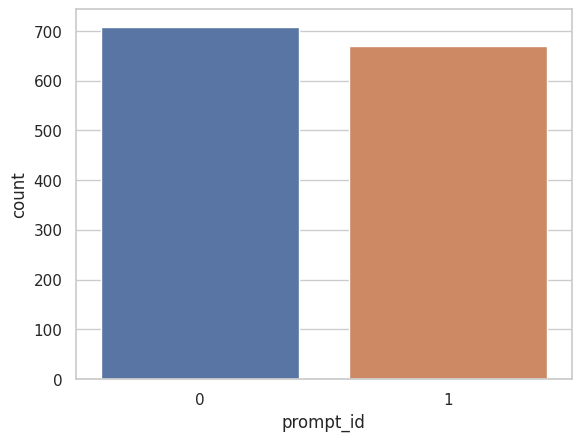

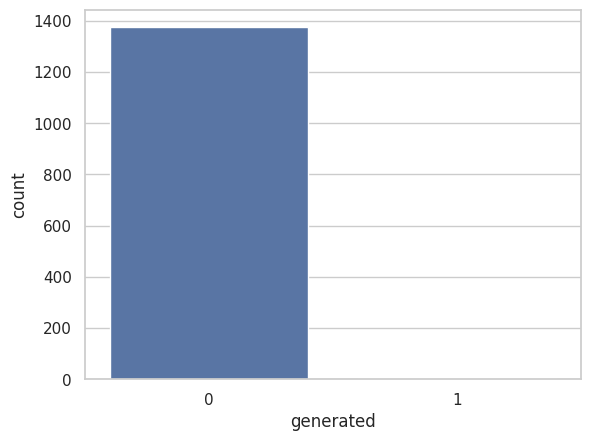

In [15]:
for i in ['prompt_id', 'generated']:
    plot = sns.countplot(data=train, x=i)
    plt.show()

*Prompt IDs are relatively balanced, slightly favoring prompt 0. Highly imbalanced target; only 3 entries that are generated. Need to balance out the classes somehow.*

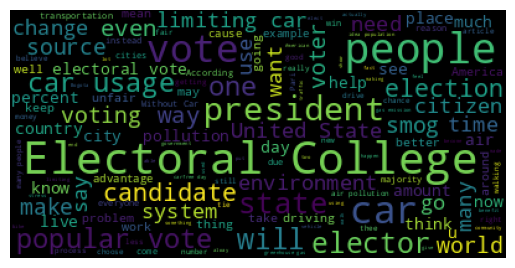

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
text = " ".join(i for i in train.text)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

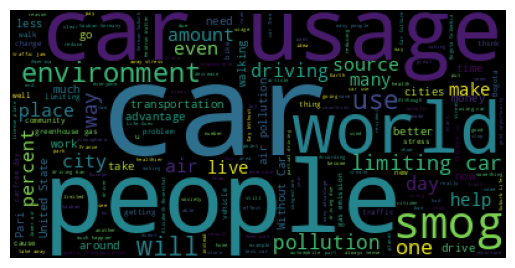

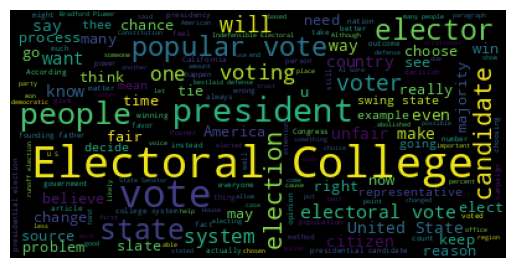

In [17]:
for i in train['prompt_id'].unique():
    text = " ".join(i for i in train[train['prompt_id'] == i].text)
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

*Indeed, Prompt 0 is all about cars, smog, people, and world, while Prompt 1 is all about the Electoral College in elections. Let's split by the generated text now.*

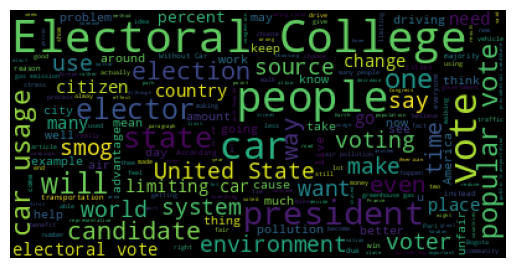

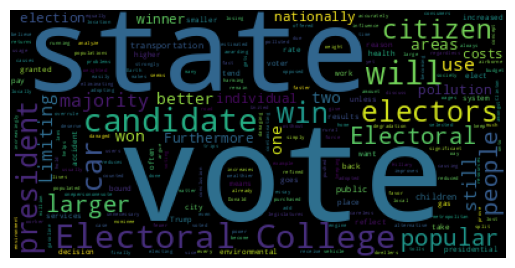

In [18]:
for i in train['generated'].unique():
    text = " ".join(i for i in train[train['generated'] == i].text)
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [19]:
train[train['generated'] == 1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


*The terms from Prompt 1 are more prevalent in the wordcloud because there are two generated pieces of text from Prompt 1 and just one for Prompt 0. Let's take a look at the length of the text.*

<Axes: xlabel='word_lengths', ylabel='Count'>

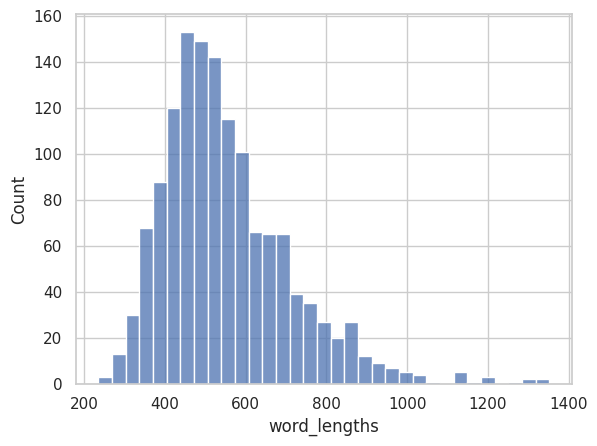

In [20]:
train['word_lengths'] = train['text'].apply(lambda x: len(x.split(' ')))
sns.histplot(data=train['word_lengths'])

*We can see that the lengths of each essay tend to be skewed right.*

<Axes: xlabel='prompt_id', ylabel='word_lengths'>

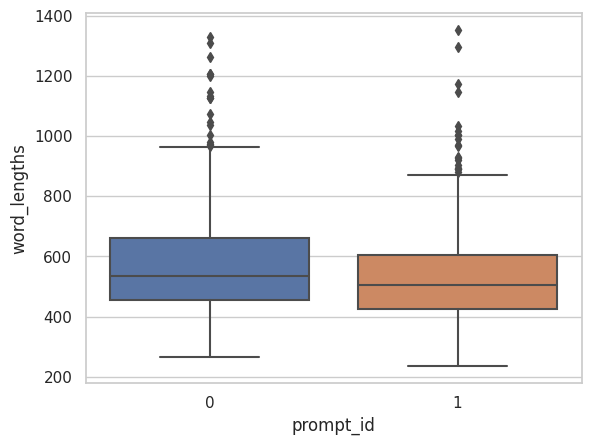

In [21]:
sns.boxplot(data=train, y='word_lengths', x='prompt_id')

<Axes: xlabel='generated', ylabel='word_lengths'>

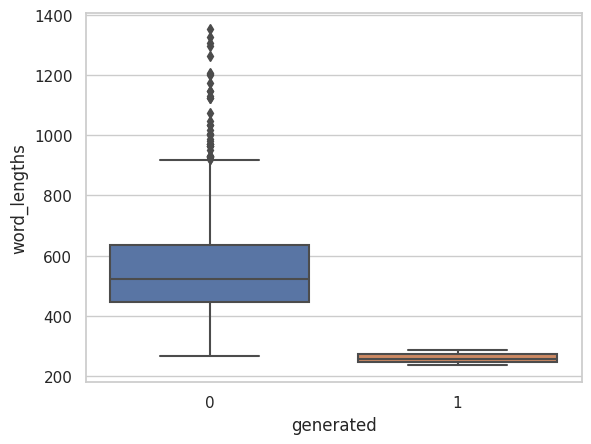

In [22]:
sns.boxplot(data=train, y='word_lengths', x='generated')

*However, the generated essays never exceed 300 words in length while many written essays are between 400 and 600 words in length. This is almost a dead giveaway that an essay is generated with our current dataset.*

<Axes: xlabel='char_lengths', ylabel='Count'>

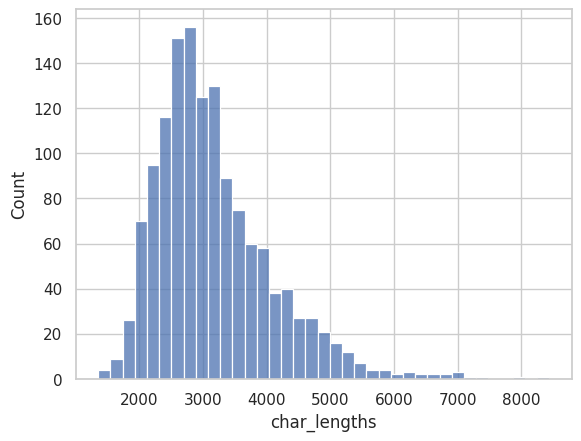

In [23]:
train['char_lengths'] = train['text'].apply(lambda x: len([*x]))
sns.histplot(data=train['char_lengths'])

<Axes: xlabel='prompt_id', ylabel='char_lengths'>

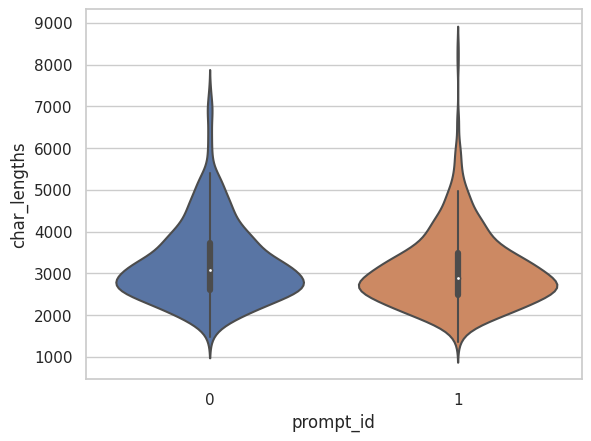

In [24]:
sns.violinplot(data=train, y='char_lengths', x='prompt_id')

<Axes: xlabel='generated', ylabel='char_lengths'>

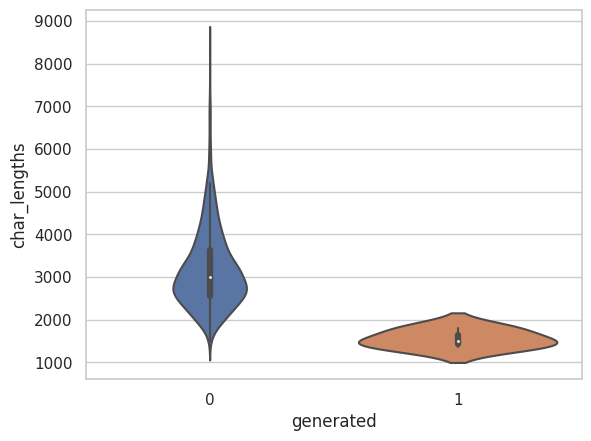

In [25]:
sns.violinplot(data=train, y='char_lengths', x='generated')

<Axes: xlabel='avg_char_lengths', ylabel='Count'>

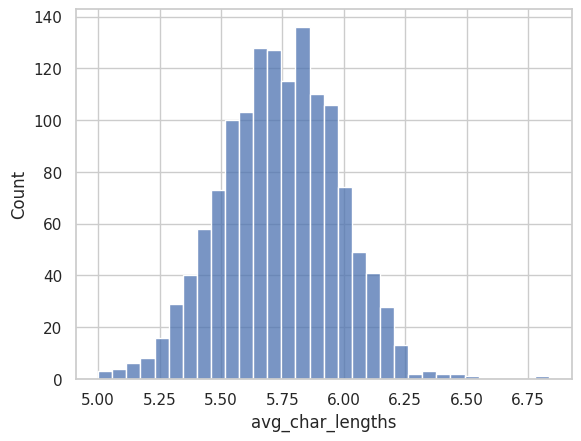

In [26]:
train['avg_char_lengths'] = train['text'].apply(lambda x: len([*x]))/train['word_lengths']
sns.histplot(data=train['avg_char_lengths'])

*Average character lengths though are approximately normal.*

<Axes: xlabel='prompt_id', ylabel='avg_char_lengths'>

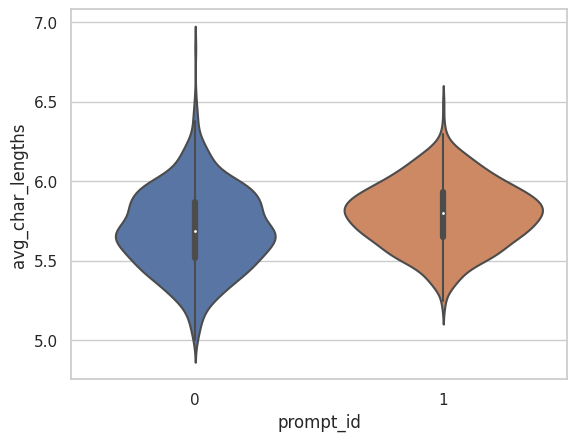

In [27]:
sns.violinplot(data=train, y='avg_char_lengths', x='prompt_id')

<Axes: xlabel='generated', ylabel='avg_char_lengths'>

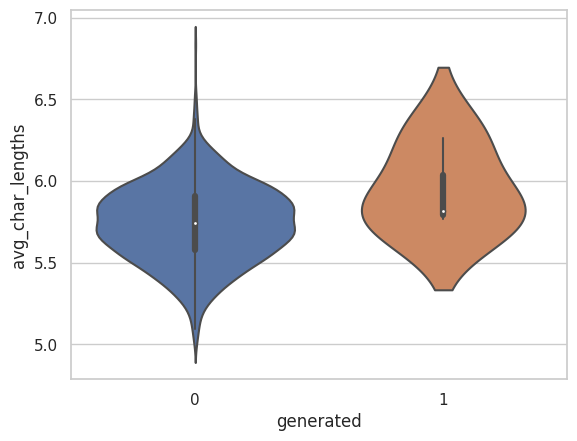

In [28]:
sns.violinplot(data=train, y='avg_char_lengths', x='generated')

*We can see that on average, generated text has longer words than non-generated text, although part of that may be due to prompt 1 having longer words than prompt 0, and there is more generated text for prompt 1.*

<Axes: xlabel='sentence_lengths', ylabel='Count'>

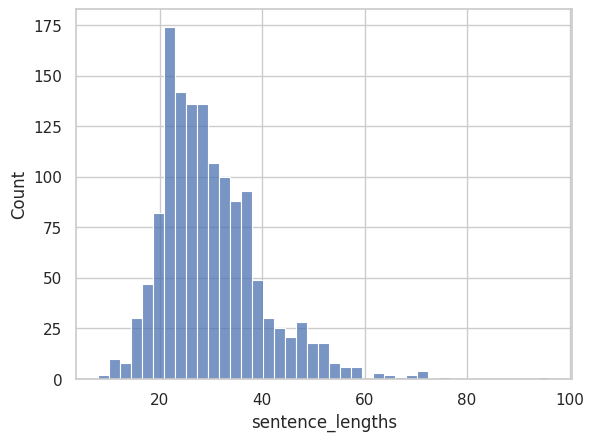

In [29]:
train['sentence_lengths'] = train['text'].apply(lambda x: len(x.split('.')))
sns.histplot(data=train['sentence_lengths'])

<Axes: xlabel='prompt_id', ylabel='sentence_lengths'>

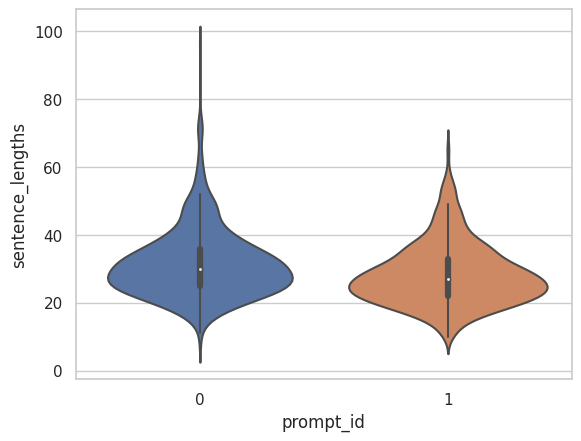

In [30]:
sns.violinplot(data=train, y='sentence_lengths', x='prompt_id')

<Axes: xlabel='generated', ylabel='sentence_lengths'>

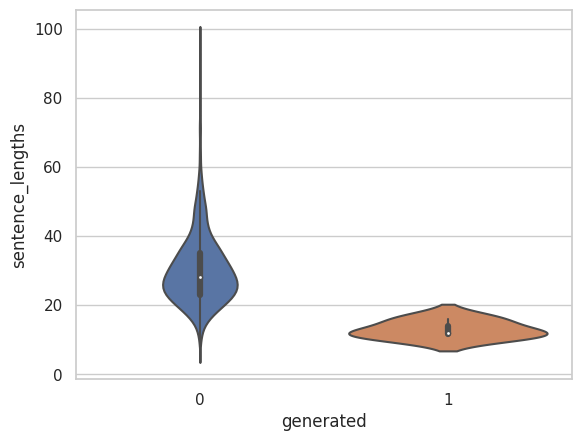

In [31]:
sns.violinplot(data=train, y='sentence_lengths', x='generated')

> Sentence lengths are skewed right, and we can see that generated text uses significantly fewer sentences than non-generated text.

In [32]:
new_data=pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')
new_data.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [33]:
new_data.label.value_counts()

label
0    27371
1    17497
Name: count, dtype: int64

In [34]:
train_prompts.prompt_name.value_counts()

prompt_name
Car-free cities                     1
Does the electoral college work?    1
Name: count, dtype: int64

In [35]:
new_data.prompt_name.value_counts()

prompt_name
Distance learning                        5554
Seeking multiple opinions                5176
Car-free cities                          4717
Does the electoral college work?         4434
Facial action coding system              3084
Mandatory extracurricular activities     3077
Summer projects                          2701
Driverless cars                          2250
Exploring Venus                          2176
Cell phones at school                    2119
Grades for extracurricular activities    2116
Community service                        2092
"A Cowboy Who Rode the Waves"            1896
The Face on Mars                         1893
Phones and driving                       1583
Name: count, dtype: int64

In [36]:
new_=new_data.iloc[:, 0:2][new_data['prompt_name'].isin(train_prompts['prompt_name'].values)]
new_

,text,label
1168,Cars have been around for awhile and they have...,0
1169,Have you ever thought what it would be like no...,0
1170,What you are about to read is going to give yo...,0
1171,cars have many flaws nd and in this day and ag...,0
1172,There are many advantages of limiting car usag...,0
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


In [37]:
train=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [38]:
test=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [39]:
train_prompts=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [40]:
train['prompt_id'].value_counts()

prompt_id
0    708
1    670
Name: count, dtype: int64

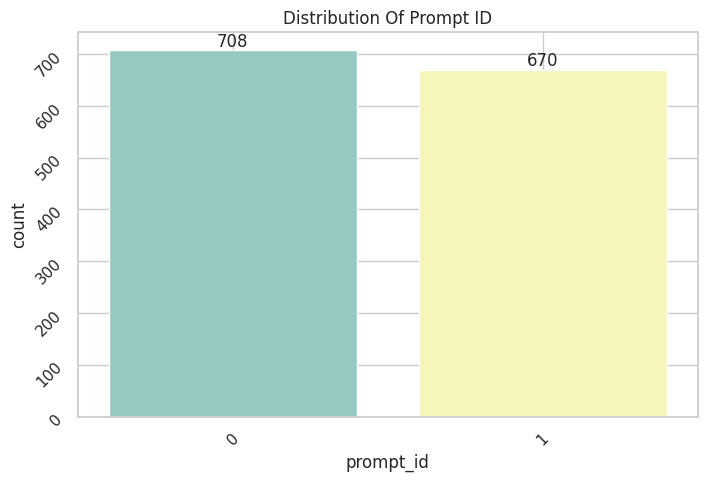

In [41]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train,x="prompt_id",palette='Set3')
abs_values = train['prompt_id'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Prompt ID")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [42]:
train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

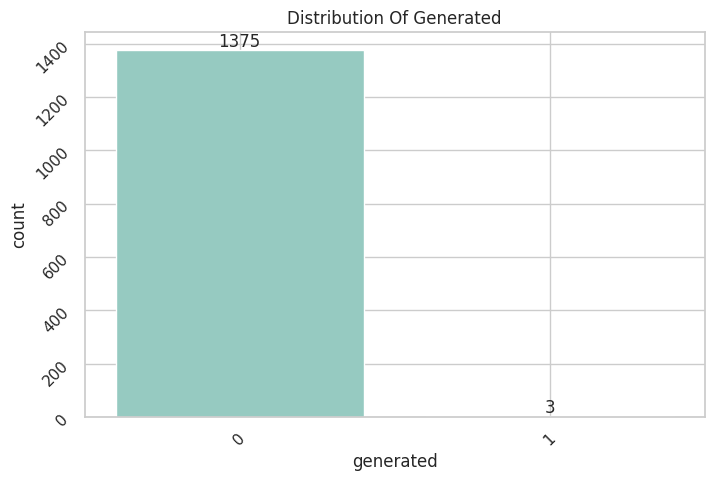

In [43]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train,x="generated",palette='Set3')
abs_values = train['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Generated")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [44]:
train_prompts.prompt_name.value_counts()

prompt_name
Car-free cities                     1
Does the electoral college work?    1
Name: count, dtype: int64

In [45]:
new_data.prompt_name.value_counts()

prompt_name
Distance learning                        5554
Seeking multiple opinions                5176
Car-free cities                          4717
Does the electoral college work?         4434
Facial action coding system              3084
Mandatory extracurricular activities     3077
Summer projects                          2701
Driverless cars                          2250
Exploring Venus                          2176
Cell phones at school                    2119
Grades for extracurricular activities    2116
Community service                        2092
"A Cowboy Who Rode the Waves"            1896
The Face on Mars                         1893
Phones and driving                       1583
Name: count, dtype: int64

In [46]:
new_=new_data.iloc[:, 0:2][new_data['prompt_name'].isin(train_prompts['prompt_name'].values)]
new_

,text,label
1168,Cars have been around for awhile and they have...,0
1169,Have you ever thought what it would be like no...,0
1170,What you are about to read is going to give yo...,0
1171,cars have many flaws nd and in this day and ag...,0
1172,There are many advantages of limiting car usag...,0
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


In [47]:
t=train.iloc[:,2:]
t.columns=['text','label']
train_data=pd.concat([new_,t])
train_data=train_data.reset_index().iloc[:,1:]
train_data.head()

,text,label
0,Cars have been around for awhile and they have...,0
1,Have you ever thought what it would be like no...,0
2,What you are about to read is going to give yo...,0
3,cars have many flaws nd and in this day and ag...,0
4,There are many advantages of limiting car usag...,0


In [48]:
train_data.label.value_counts()

label
0    6755
1    3774
Name: count, dtype: int64

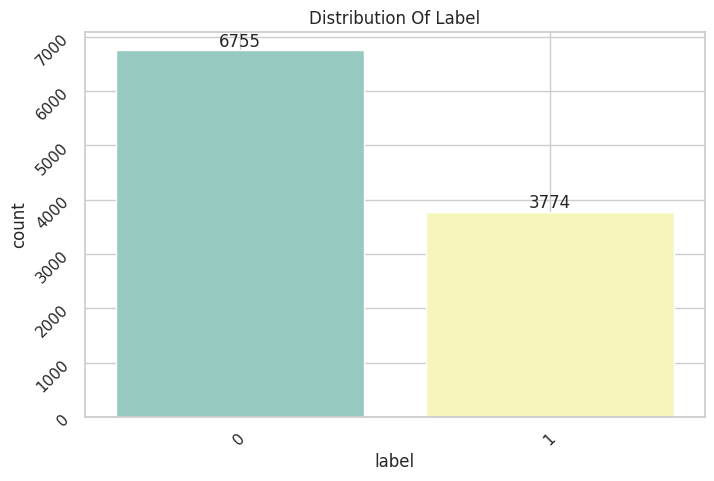

In [49]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train_data,x="label",palette='Set3')
abs_values = train_data['label'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Label")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### Data cleaning

In [50]:
def Clean(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.regex_replace(text, '\.\.\.', ' ')
    text = tf.strings.join(['',text, ''], separator=' ')
    return text
def clean_text(text):
    # Remove Twitter handles starting with '@'
    text = re.sub(r'@\w+', '', text)
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [51]:
train_data['text'][0]

'Cars have been around for awhile and they have had a major impact on society. Many people believe that there is no problem with the frequency of cars being driven. But, there are many advantages to less car use such as improving our cities and suburbs, improving safety, and decreasing pollution.\n\nMany have tried to make cities a little more dense and better for walking but nothing has seemed to work; therefore, they have moved on to suburbs. Now, people are trying to make suburbs better for getting around while walking instead of driving. By doing so, places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option. By having these suburbs, and soon hopefully cities, reduce the amount of cars used, the people living in these areas will be able to accomplish more in a healthier and safer way.\n\nSafety has been an issue in almost all areas due to a variety of reasons; one being cars. People pass by "Drive Safely" signs

In [52]:
Clean(train_data['text'][0])

<tf.Tensor: shape=(), dtype=string, numpy=b' cars have been around for awhile and they have had a major impact on society .  many people believe that there is no problem with the frequency of cars being driven .  but ,  there are many advantages to less car use such as improving our cities and suburbs ,  improving safety ,  and decreasing pollution . many have tried to make cities a little more dense and better for walking but nothing has seemed to work therefore ,  they have moved on to suburbs .  now ,  people are trying to make suburbs better for getting around while walking instead of driving .  by doing so ,  places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option .  by having these suburbs ,  and soon hopefully cities ,  reduce the amount of cars used ,  the people living in these areas will be able to accomplish more in a healthier and safer way . safety has been an issue in almost all areas due to a vari

In [53]:
clean_text(train_data['text'][0])

'cars have been around for awhile and they have had a major impact on society many people believe that there is no problem with the frequency of cars being driven but there are many advantages to less car use such as improving our cities and suburbs improving safety and decreasing pollution many have tried to make cities a little more dense and better for walking but nothing has seemed to work therefore they have moved on to suburbs now people are trying to make suburbs better for getting around while walking instead of driving by doing so places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option by having these suburbs and soon hopefully cities reduce the amount of cars used the people living in these areas will be able to accomplish more in a healthier and safer way safety has been an issue in almost all areas due to a variety of reasons one being cars people pass by drive safely signs or memorials on the side o

### Vectorization

In [54]:
max_features = 75000
embedding_dim = 64
sequence_length = 512*2
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=Clean ,
    max_tokens=max_features,
    ngrams = (3,5),
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)
vectorize_layer.adapt(train_data['text'])
Text = vectorize_layer(train_data['text']).numpy()
Text

array([[ 1138, 19101,  5729, ...,     1,     1,     1],
       [ 3796, 10859,     1, ...,     0,     0,     0],
       [28184,     1, 53697, ...,     1,     1,     1],
       ...,
       [    1, 31053,     1, ...,     1,     1,     1],
       [24714,  8587,     1, ...,     1,     1,     1],
       [ 1138, 19101, 21592, ...,     0,     0,     0]])

In [55]:
sm = SMOTE(random_state=44)
Text,labels= sm.fit_resample(Text,train_data['label'])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(Text,labels, test_size=0.2, random_state=44, shuffle =True,stratify=labels)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (10808, 1024)
X_test shape is  (2702, 1024)
y_train shape is  (10808,)
y_test shape is  (2702,)


### Model Implementation

In [57]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
transformer_block = TransformerBlock(embedding_dim, 2, 32)
x = transformer_block(x)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 embedding (Embedding)       (None, 1024, 64)          4800000   
                                                                 
 bidirectional (Bidirection  (None, 1024, 64)          24832     
 al)                                                             
                                                                 
 transformer_block (Transfo  (None, 1024, 64)          37664     
 rmerBlock)                                                      
                                                                 
 conv1d (Conv1D)             (None, 340, 128)          57472     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0     

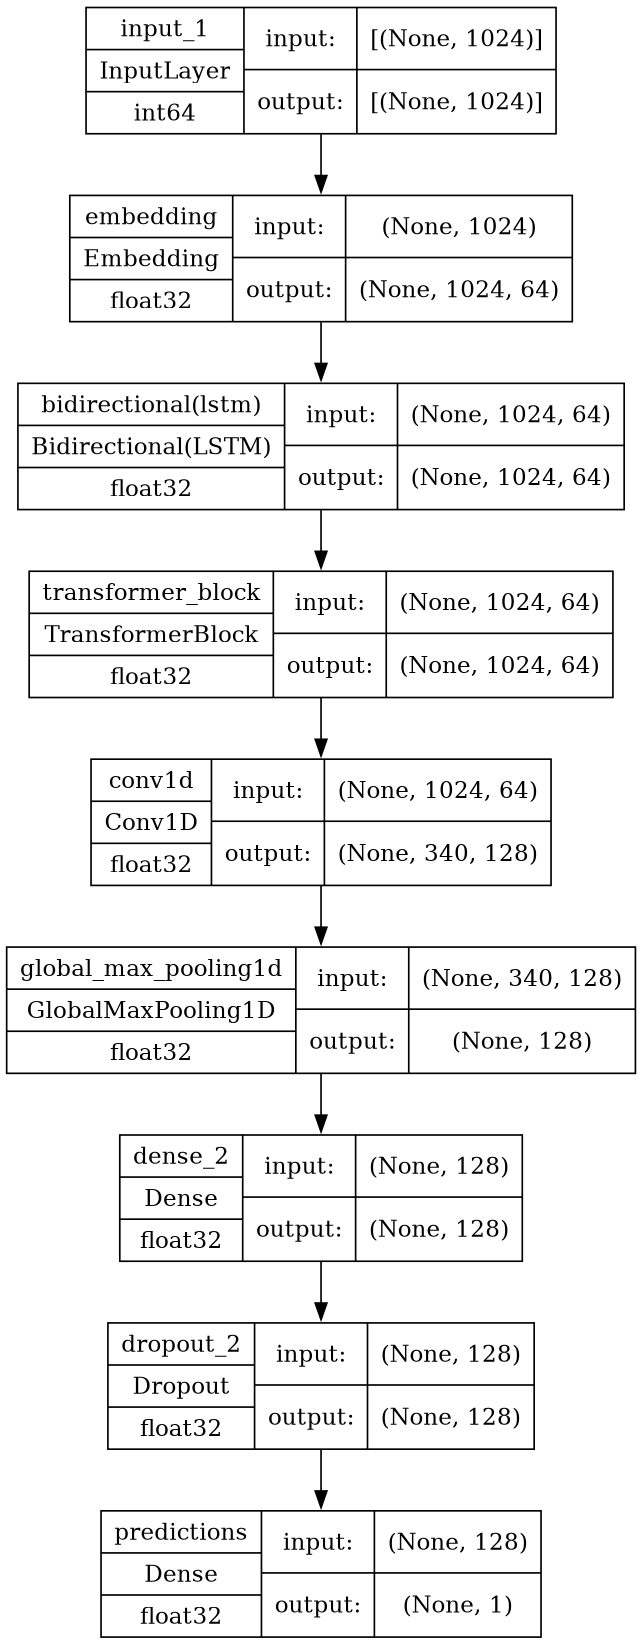

In [58]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [59]:
checkpoint_cb =ModelCheckpoint("model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=10, validation_split=.1, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
304/304 [==============================] - 460s 1s/step - loss: 0.1131 - accuracy: 0.9571 - val_loss: 0.1131 - val_accuracy: 0.9519
Epoch 2/10
304/304 [==============================] - 456s 1s/step - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.0170 - val_accuracy: 0.9926
Epoch 3/10
304/304 [==============================] - 453s 1s/step - loss: 3.7472e-04 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 0.9944
Epoch 4/10
304/304 [==============================] - 456s 2s/step - loss: 4.0922e-05 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 0.9944
Epoch 5/10
304/304 [==============================] - 452s 1s/step - loss: 3.2512e-05 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9954
Epoch 6/10
304/304 [==============================] - 457s 2s/step - loss: 2.6180e-05 - accuracy: 1.0000 - val_loss: 0.0219 - val_accuracy: 0.9944
Epoch 7/10
304/304 [==============================] - 459s 2s/step - loss: 6.1243e-06 - accuracy: 1.0000 - val_loss: 0.0241 - 

In [60]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.113067,0.957130,0.113108,0.951896
1,0.008088,0.997944,0.016957,0.992599
2,0.000375,1.000000,0.018583,0.994450
3,0.000041,1.000000,0.016440,0.994450
4,0.000033,1.000000,0.016687,0.995375
5,0.000026,1.000000,0.021919,0.994450
6,0.000006,1.000000,0.024057,0.994450


In [61]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

85/85 [==============================] - 46s 546ms/step - loss: 0.0148 - accuracy: 0.9974
Test Loss = 0.014832664281129837
Test Accuracy = 0.9974093437194824


In [62]:
predictions = model.predict(X_test)
y_pred = np.where(predictions>=.5,1,0)
y_test_1d = np.ravel(y_test)
y_pred_1d = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test_1d, 'Prediction': y_pred_1d})
df

85/85 [==============================] - 47s 547ms/step


,Actual,Prediction
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
2697,0,0
2698,1,1
2699,0,0
2700,1,1


array([[1349,    2],
       [   5, 1346]])

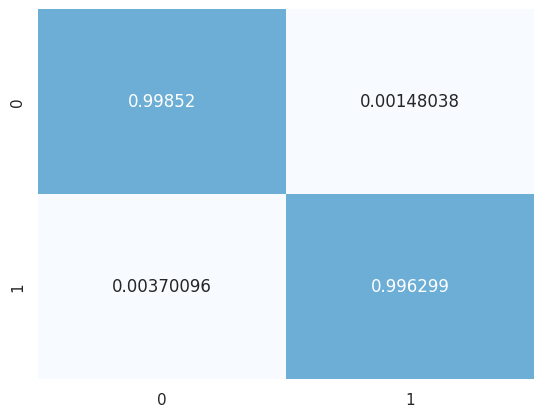

In [63]:
CM = confusion_matrix(y_test_1d,y_pred_1d)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [64]:
ClassificationReport = classification_report(y_test_1d,y_pred_1d)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      1.00      1.00      1351
           1       1.00      1.00      1.00      1351

    accuracy                           1.00      2702
   macro avg       1.00      1.00      1.00      2702
weighted avg       1.00      1.00      1.00      2702



In [65]:
test_text = vectorize_layer(test['text']).numpy()
predictions = model.predict(test_text)
y_pred = np.where(predictions>=.5,1,0)
sub=pd.DataFrame()
sub['id'],sub['generated']=test['id'],predictions
sub.to_csv('/kaggle/working/submission.csv', index=False)
sub

1/1 [==============================] - 0s 118ms/step


,id,generated
0,0000aaaa,0.949619
1,1111bbbb,0.949619
2,2222cccc,0.949619
